 Required Libraries

In [ ]:
! python -m venv llm_lab
! source llm_lab/bin/activate # On Windows: llm_lab\Scripts\activate
! pip install numpy torch matplotlib jupyter

Error: Command '['/content/llm_lab/bin/python3', '-m', 'ensurepip', '--upgrade', '--default-pip']' returned non-zero exit status 1.
/bin/bash: line 1: llm_lab/bin/activate: No such file or directory


 Jupyter Notebook Setup

In [ ]:
#  ! jupyter notebook

 Importing Libraries


In [ ]:
 import numpy as np
 import torch
 import torch.nn as nn
 import torch.nn.functional as F
 import matplotlib.pyplot as plt
 import re
 import random
 from collections import Counter
 # Set random seeds for reproducibility
 torch.manual_seed(42)
 np.random.seed(42)
 random.seed(42)
 device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
 print(f"Using device: {device}")

Using device: cuda


Preparing a Simple Dataset

In [ ]:
# Sample text corpus
corpus = """
Natural language processing has improved significantly with transformer models.
Large language models like GPT can generate human-like text.
Attention mechanisms help models focus on relevant parts of the input.
Transformers have revolutionized machine translation and text generation.
The self-attention mechanism is a key innovation in transformer architectures.
Tokenization is the first step in processing text for language models.
Neural networks learn to represent words as vectors in a continuous space.
Contextual embeddings capture word meaning based on surrounding context.
Training language models requires large amounts of text data.
Language models can be fine-tuned for specific tasks like summarization.
"""
# Clean the text
corpus = corpus.strip().lower()
sentences = [s.strip() for s in corpus.split('.') if s.strip()]
print(f"Number of sentences: {len(sentences)}")
print(f"Sample sentence: {sentences[0]}")

Number of sentences: 10
Sample sentence: natural language processing has improved significantly with transformer models


Implementing a Simple Tokenizer

In [ ]:
# class CharacterTokenizer:
#   def __init__(self):
#       self.char_to_idx = {}
#       self.idx_to_char = {}
#       self.vocab_size = 0

#   def fit(self, texts):
#       """Build vocabulary from a list of texts"""
#       chars = set()
#       for text in texts:
#           chars.update(text)

#       # Sort characters for deterministic mapping
#       sorted_chars = sorted(list(chars))

#       # Create mappings
#       self.char_to_idx = {char: idx for idx, char in enumerate(sorted_chars)}
#       self.idx_to_char = {idx: char for idx, char in enumerate(sorted_chars)}
#       self.vocab_size = len(sorted_chars)

#       return self

#   def encode(self, text):
#       """Convert text to token indices"""
#       return [self.char_to_idx[char] for char in text]

#   def decode(self, indices):
#       """Convert token indices back to text"""
#       return ''.join([self.idx_to_char[idx] for idx in indices])

#   def __len__(self):
#       return self.vocab_size
# # Create and fit the tokenizer
# tokenizer = CharacterTokenizer().fit(sentences)
# print(f"Vocabulary size: {len(tokenizer)}")
# # Test encoding and decoding
# sample_text = sentences[0]
# encoded = tokenizer.encode(sample_text)
# decoded = tokenizer.decode(encoded)
# print(f"Original: {sample_text}")
# print(f"Encoded: {encoded[:10]}...")
# print(f"Decoded: {decoded}")

In [ ]:
class WordTokenizer:
    def __init__(self):
        self.word_to_idx = {}
        self.idx_to_word = {}
        self.vocab_size = 0

    def fit(self, texts):
        """Build vocabulary from a list of texts"""
        words = set()
        for text in texts:
            words.update(text.split())  # Tokenize by words

        # Sort words for deterministic mapping
        sorted_words = sorted(list(words))

        # Create mappings
        self.word_to_idx = {word: idx for idx, word in enumerate(sorted_words)}
        self.idx_to_word = {idx: word for idx, word in enumerate(sorted_words)}
        self.vocab_size = len(sorted_words)

        return self

    def encode(self, text):
        """Convert text to token indices"""
        return [self.word_to_idx[word] for word in text.split()]

    def decode(self, indices):
        """Convert token indices back to text"""
        return ' '.join([self.idx_to_word[idx] for idx in indices])

    def __len__(self):
        return self.vocab_size


# Example usage:
tokenizer = WordTokenizer().fit(sentences)
print(f"Vocabulary size: {len(tokenizer)}")

# Test encoding and decoding
sample_text = sentences[0]
encoded = tokenizer.encode(sample_text)
decoded = tokenizer.decode(encoded)
print(f"Original: {sample_text}")
print(f"Encoded: {encoded[:10]}...")
print(f"Decoded: {decoded}")


Vocabulary size: 72
Original: natural language processing has improved significantly with transformer models
Encoded: [41, 32, 47, 22, 26, 53, 69, 65, 40]...
Decoded: natural language processing has improved significantly with transformer models


Creating Training Data

In [ ]:
def prepare_data(sentences, tokenizer, seq_length=20):
  """Prepare input-output pairs for training"""
  inputs = []
  targets = []

  for sentence in sentences:
      # Skip sentences that are too short
      if len(sentence) <= seq_length + 1:
          continue

      # Tokenize the sentence
      tokens = tokenizer.encode(sentence)

      # Create input-target pairs with a sliding window
      for i in range(len(tokens) - seq_length):
          input_seq = tokens[i:i+seq_length]
          target_seq = tokens[i+1:i+seq_length+1]  # Next token prediction

          inputs.append(input_seq)
          targets.append(target_seq)

  # Convert to PyTorch tensors
  inputs = torch.tensor(inputs, dtype=torch.long)
  targets = torch.tensor(targets, dtype=torch.long)

  return inputs, targets
# Prepare training data
seq_length = 10
inputs, targets = prepare_data(sentences, tokenizer, seq_length)
print(f"Number of training examples: {len(inputs)}")
print(f"Input shape: {inputs.shape}")
print(f"Target shape: {targets.shape}")
# Sample data point
idx = 0
print(f"Sample input: {tokenizer.decode(inputs[idx].tolist())}")
print(f"Sample target: {tokenizer.decode(targets[idx].tolist())}")

Number of training examples: 4
Input shape: torch.Size([4, 10])
Target shape: torch.Size([4, 10])
Sample input: attention mechanisms help models focus on relevant parts of the
Sample target: mechanisms help models focus on relevant parts of the input


Implementing the Embedding Layer

In [ ]:
class EmbeddingLayer(nn.Module):
  def __init__(self, vocab_size, embed_dim):
      super(EmbeddingLayer, self).__init__()
      self.embedding = nn.Embedding(vocab_size, embed_dim)
      self.embed_dim = embed_dim

  def forward(self, x):
      # x shape: (batch_size, seq_length)
      # output shape: (batch_size, seq_length, embed_dim)
      return self.embedding(x) * (self.embed_dim ** 0.5)  # Scaling factor
# Test the embedding layer
vocab_size = len(tokenizer)
embed_dim = 32
embedding_layer = EmbeddingLayer(vocab_size, embed_dim)
sample_batch = inputs[:3]  # Take 3 examples
embedded = embedding_layer(sample_batch)
print(f"Sample batch shape: {sample_batch.shape}")
print(f"Embedded output shape: {embedded.shape}")

Sample batch shape: torch.Size([3, 10])
Embedded output shape: torch.Size([3, 10, 32])


Implementing Positional Encoding

Shape after positional encoding: torch.Size([3, 10, 32])


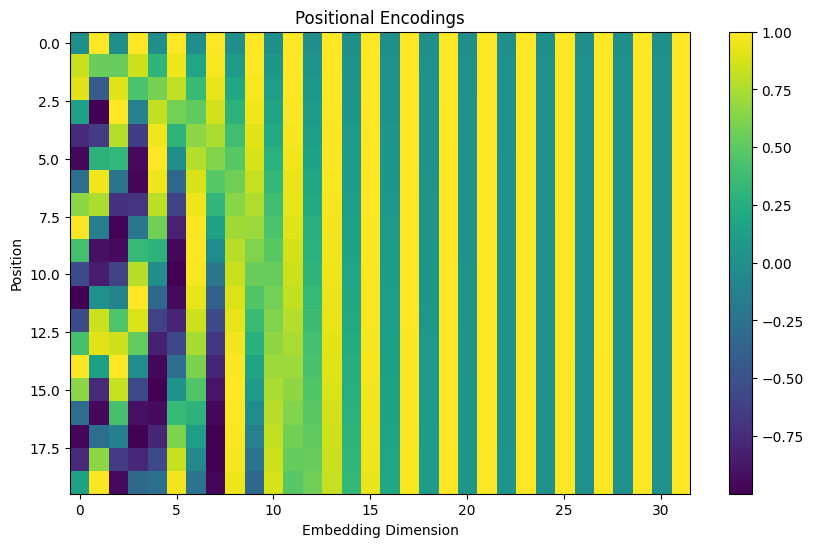

In [ ]:
class PositionalEncoding(nn.Module):
  def __init__(self, embed_dim, max_seq_length=5000):
      super(PositionalEncoding, self).__init__()

      # Create positional encoding matrix
      pe = torch.zeros(max_seq_length, embed_dim)
      position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
      div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-np.log(10000.0) / embed_dim))

      # Apply sine to even indices
      pe[:, 0::2] = torch.sin(position * div_term)
      # Apply cosine to odd indices
      pe[:, 1::2] = torch.cos(position * div_term)

      # Register as buffer (not model parameter)
      self.register_buffer('pe', pe.unsqueeze(0))

  def forward(self, x):
      # x shape: (batch_size, seq_length, embed_dim)
      # Add positional encoding
      return x + self.pe[:, :x.size(1), :]
# Test positional encoding
pos_encoding = PositionalEncoding(embed_dim)
embedded_with_pos = pos_encoding(embedded)
print(f"Shape after positional encoding: {embedded_with_pos.shape}")
# Visualize positional encodings
plt.figure(figsize=(10, 6))
plt.imshow(pos_encoding.pe[0, :20, :].cpu().numpy(), aspect='auto', cmap='viridis')
plt.xlabel('Embedding Dimension')
plt.ylabel('Position')
plt.colorbar()
plt.title('Positional Encodings')
plt.show()

Implementing Self-Attention Mechanism

Attention output shape: torch.Size([3, 10, 32])
Attention weights shape: torch.Size([3, 4, 10, 10])


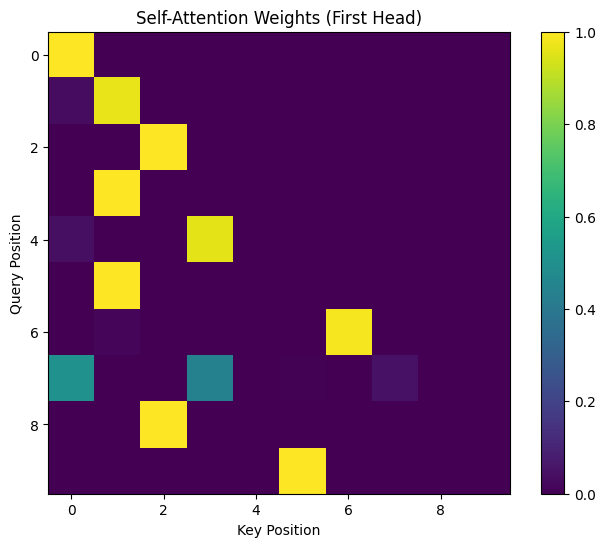

In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads): # Changed _init_ to __init__
        super(SelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        assert self.head_dim * num_heads == embed_dim, "Embedding dimension must be divisible by number of heads"

        # Combine all Q, K, V projections into one linear layer for efficiency
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.fc_out = nn.Linear(embed_dim, embed_dim)

    def forward(self, x, mask=None):
        batch_size, seq_length, embed_dim = x.size()

        # Compute Q, K, V in one big matrix and split
        qkv = self.qkv(x)  # (batch_size, seq_length, 3 * embed_dim)
        qkv = qkv.reshape(batch_size, seq_length, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # (3, batch_size, num_heads, seq_length, head_dim)
        queries, keys, values = qkv[0], qkv[1], qkv[2]  # Each is (batch_size, num_heads, seq_length, head_dim)

        # Compute scaled dot-product attention
        scale = self.head_dim ** 0.5
        energy = torch.matmul(queries, keys.transpose(-2, -1)) / scale  # (batch_size, num_heads, seq_length, seq_length)

        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        attention = F.softmax(energy, dim=-1)

        out = torch.matmul(attention, values)  # (batch_size, num_heads, seq_length, head_dim)
        out = out.transpose(1, 2).reshape(batch_size, seq_length, embed_dim)  # (batch_size, seq_length, embed_dim)

        out = self.fc_out(out)  # Final linear projection
        return out, attention
# Create causal mask for language modeling
def create_causal_mask(size):
  mask = torch.tril(torch.ones(size, size))
  return mask.unsqueeze(0).unsqueeze(0)  # (1, 1, size, size)
# Test self-attention
num_heads = 4
attention = SelfAttention(embed_dim, num_heads).to(device) # Move the model to the device
mask = create_causal_mask(seq_length).to(device)
attention_output, attention_weights = attention(embedded_with_pos.to(device), mask) # Move the input to the device
print(f"Attention output shape: {attention_output.shape}")
print(f"Attention weights shape: {attention_weights.shape}")
# Visualize attention weights for the first head
plt.figure(figsize=(8, 6))
plt.imshow(attention_weights[0, 0, :, :].detach().cpu().numpy(), cmap='viridis')
plt.xlabel('Key Position')
plt.ylabel('Query Position')
plt.colorbar()
plt.title('Self-Attention Weights (First Head)')
plt.show()

Implementing Feed-Forward Network

In [ ]:
class FeedForward(nn.Module):
  def __init__(self, embed_dim, ff_dim):
      super(FeedForward, self).__init__()
      self.fc1 = nn.Linear(embed_dim, ff_dim)
      self.fc2 = nn.Linear(ff_dim, embed_dim)
      self.activation = nn.GELU()  # GELU activation as used in modern transformers

  def forward(self, x):
      # x shape: (batch_size, seq_length, embed_dim)
      x = self.fc1(x)  # (batch_size, seq_length, ff_dim)
      x = self.activation(x)
      x = self.fc2(x)  # (batch_size, seq_length, embed_dim)
      return x
# Test feed-forward network
ff_dim = embed_dim * 4  # Common practice to use 4x the embedding dimension
feed_forward = FeedForward(embed_dim, ff_dim).to(device) # Move feed_forward to the same device as attention_output
ff_output = feed_forward(attention_output)
print(f"Feed-forward output shape: {ff_output.shape}")

Feed-forward output shape: torch.Size([3, 10, 32])


Implementing a Transformer Block

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super(TransformerBlock, self).__init__()

        self.attention = SelfAttention(embed_dim, num_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.feed_forward = FeedForward(embed_dim, ff_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Pre-LN: Apply normalization before attention
        norm_x = self.norm1(x)
        attention_output, _ = self.attention(norm_x, mask)
        x = x + self.dropout(attention_output)  # Residual connection

        # Pre-LN: Apply normalization before feed-forward
        norm_x = self.norm2(x)
        ff_output = self.feed_forward(norm_x)
        x = x + self.dropout(ff_output)  # Residual connection

        return x
# Test transformer block
transformer_block = TransformerBlock(32, num_heads, ff_dim).to(device)
block_output = transformer_block(embedded_with_pos.to(device), mask)
print(f"Transformer block output shape: {block_output.shape}")

Transformer block output shape: torch.Size([3, 10, 32])


Implementing the Complete Mini Language Model

In [ ]:
class MiniLanguageModel(nn.Module):
  def __init__(self, vocab_size, embed_dim, num_heads, ff_dim, num_layers, max_seq_length, dropout=0.1):
      super(MiniLanguageModel, self).__init__()

      self.embed_dim = embed_dim
      self.embedding = EmbeddingLayer(vocab_size, embed_dim)
      self.positional_encoding = PositionalEncoding(embed_dim, max_seq_length)

      self.transformer_blocks = nn.ModuleList(
          [TransformerBlock(embed_dim, num_heads, ff_dim, dropout) for _ in range(num_layers)]
      )

      self.fc_out = nn.Linear(embed_dim, vocab_size)
      self.dropout = nn.Dropout(dropout)

  def forward(self, x):
      # Create causal mask
      seq_length = x.shape[1]
      mask = create_causal_mask(seq_length).to(x.device)

      # Embedding and positional encoding
      x = self.embedding(x)
      x = self.positional_encoding(x)
      x = self.dropout(x)

      # Transformer blocks
      for block in self.transformer_blocks:
          x = block(x, mask)

      # Output layer
      x = self.fc_out(x)  # (batch_size, seq_length, vocab_size)

      return x
# Model hyperparameters
vocab_size = len(tokenizer)
embed_dim = 64
num_heads = 4
ff_dim = embed_dim * 4
num_layers = 2
max_seq_length = 100
dropout = 0.1
# Initialize the model
model = MiniLanguageModel(
  vocab_size=vocab_size,
  embed_dim=embed_dim,
  num_heads=num_heads,
  ff_dim=ff_dim,
  num_layers=num_layers,
  max_seq_length=max_seq_length,
  dropout=dropout
).to(device)
# Print model summary
print(model)
# Test forward pass
sample_batch = inputs[:5].to(device)  # Take 5 examples
output = model(sample_batch)
print(f"Model output shape: {output.shape}")  # Should be (batch_size, seq_length, vocab_size)

MiniLanguageModel(
  (embedding): EmbeddingLayer(
    (embedding): Embedding(72, 64)
  )
  (positional_encoding): PositionalEncoding()
  (transformer_blocks): ModuleList(
    (0-1): 2 x TransformerBlock(
      (attention): SelfAttention(
        (qkv): Linear(in_features=64, out_features=192, bias=True)
        (fc_out): Linear(in_features=64, out_features=64, bias=True)
      )
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (feed_forward): FeedForward(
        (fc1): Linear(in_features=64, out_features=256, bias=True)
        (fc2): Linear(in_features=256, out_features=64, bias=True)
        (activation): GELU(approximate='none')
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (fc_out): Linear(in_features=64, out_features=72, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)
Model output shape: torch.Size([4, 10, 72])


Training the Model

Epoch 1/50, Batch 0/1, Loss: 11.6910
Epoch 1/50, Average Loss: 11.6910
Epoch 2/50, Batch 0/1, Loss: 11.4889
Epoch 2/50, Average Loss: 11.4889
Epoch 3/50, Batch 0/1, Loss: 10.6370
Epoch 3/50, Average Loss: 10.6370
Epoch 4/50, Batch 0/1, Loss: 10.6422
Epoch 4/50, Average Loss: 10.6422
Epoch 5/50, Batch 0/1, Loss: 10.0994
Epoch 5/50, Average Loss: 10.0994
Epoch 6/50, Batch 0/1, Loss: 9.9565
Epoch 6/50, Average Loss: 9.9565
Epoch 7/50, Batch 0/1, Loss: 9.6807
Epoch 7/50, Average Loss: 9.6807
Epoch 8/50, Batch 0/1, Loss: 9.3686
Epoch 8/50, Average Loss: 9.3686
Epoch 9/50, Batch 0/1, Loss: 9.5930
Epoch 9/50, Average Loss: 9.5930
Epoch 10/50, Batch 0/1, Loss: 9.0075
Epoch 10/50, Average Loss: 9.0075
Epoch 11/50, Batch 0/1, Loss: 9.1315
Epoch 11/50, Average Loss: 9.1315
Epoch 12/50, Batch 0/1, Loss: 8.3989
Epoch 12/50, Average Loss: 8.3989
Epoch 13/50, Batch 0/1, Loss: 8.6281
Epoch 13/50, Average Loss: 8.6281
Epoch 14/50, Batch 0/1, Loss: 8.0765
Epoch 14/50, Average Loss: 8.0765
Epoch 15/50, B

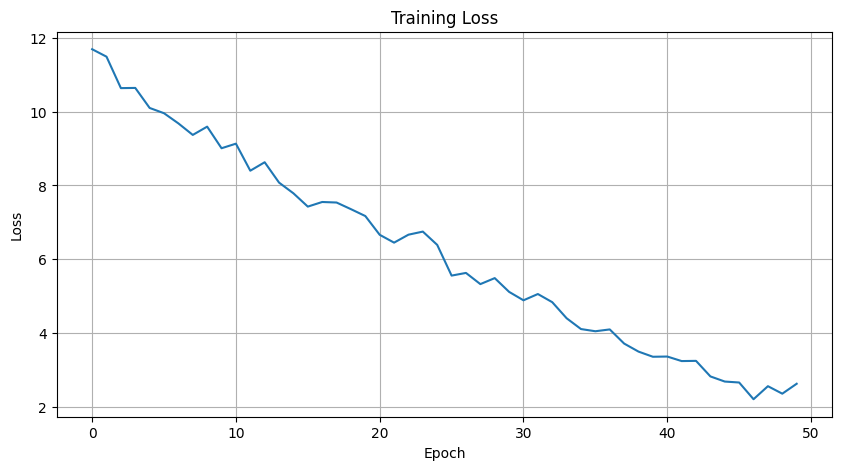

In [ ]:
def train_model(model, inputs, targets, batch_size=32, epochs=10, lr=3e-4):
  """Train the language model"""
  # Define loss function and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  # Create dataset and dataloader
  dataset = torch.utils.data.TensorDataset(inputs, targets)
  dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

  # Training loop
  model.train()
  losses = []

  for epoch in range(epochs):
      epoch_loss = 0
      for batch_idx, (batch_inputs, batch_targets) in enumerate(dataloader):
          batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)

          # Forward pass
          optimizer.zero_grad()
          outputs = model(batch_inputs)

          # Reshape outputs and targets for loss computation
          outputs = outputs.reshape(-1, vocab_size)  # (batch_size * seq_length, vocab_size)
          batch_targets = batch_targets.reshape(-1)  # (batch_size * seq_length)

          # Compute loss
          loss = criterion(outputs, batch_targets)

          # Backward pass and optimization
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
          optimizer.step()

          epoch_loss += loss.item()

          if batch_idx % 10 == 0:
              print(f"Epoch {epoch+1}/{epochs}, Batch {batch_idx}/{len(dataloader)}, Loss: {loss.item():.4f}")

      avg_epoch_loss = epoch_loss / len(dataloader)
      losses.append(avg_epoch_loss)
      print(f"Epoch {epoch+1}/{epochs}, Average Loss: {avg_epoch_loss:.4f}")

  return losses
# For the lab, we'll use a very small number of epochs
epochs = 50
batch_size = 16
losses = train_model(model, inputs, targets, batch_size=batch_size, epochs=epochs)
# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.show()

Generating Text with the Model

In [ ]:
def generate_text(model, tokenizer, prompt, max_length=100, temperature=1.0):
  """Generate text using the trained model"""
  model.eval()

  # Tokenize the prompt
  prompt_tokens = tokenizer.encode(prompt)
  input_ids = torch.tensor(prompt_tokens).unsqueeze(0).to(device)  # (1, prompt_length)

  # Generate text
  generated = list(prompt_tokens)

  with torch.no_grad():
      for _ in range(max_length):
          # Take the last seq_length tokens if input is too long
          if input_ids.size(1) > seq_length:
              input_ids = input_ids[:, -seq_length:]

          # Forward pass
          outputs = model(input_ids)

          # Get the next token probabilities
          next_token_logits = outputs[:, -1, :] / temperature

          # Sample from the distribution
          probs = F.softmax(next_token_logits, dim=-1)
          next_token = torch.multinomial(probs, num_samples=1)

          # Add the next token to the sequence
          input_ids = torch.cat([input_ids, next_token], dim=1)
          generated.append(next_token.item())

          # Stop if we generate the end of sentence token (if you have one)
          # if next_token.item() == eos_token_id:
          #     break

  # Convert back to text
  generated_text = tokenizer.decode(generated)

  return generated_text
# Generate text
prompt = "language models"
generated_text = generate_text(
  model=model,
  tokenizer=tokenizer,
  prompt=prompt,
  max_length=15,
  temperature=0.5
)
print(f"Prompt: {prompt}")
print(f"Generated text: {generated_text}")

Prompt: language models
Generated text: language models focus in a continuous mechanism gpt neural networks learn to represent words as vectors transformer
